# Testing the effective area implementation in Stan

In [16]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import stan_utility

from aeff_calculator.aeff_calculator import effective_area

In [17]:
random_seed = 19920715

## Effective area spline

In [18]:
aeff = effective_area("nue_CC")

... creating effective area spline for interaction nue_CC , done!


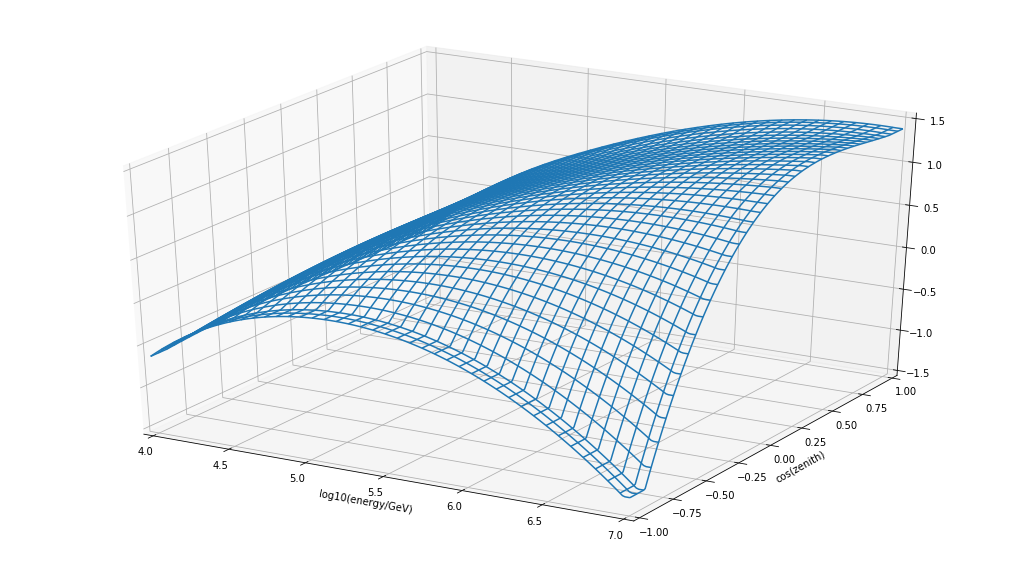

In [19]:
# Plot for energy range of interest
x = np.linspace(3.99, 7.01, 200)
y = np.linspace(-1.01, 1.01, 200)
xx, yy = np.meshgrid(x, y)
xx = xx.T
yy = yy.T
z = aeff.eval(x, y)

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, z, rstride=5, cstride=5)

ax.set_xlabel('log10(energy/GeV)')
ax.set_ylabel('cos(zenith)')
ax.set_xlim([4.0, 7.0])
ax.set_ylim([-1.0, 1.0])
ax.set_zlim([-1.5, 1.5]);

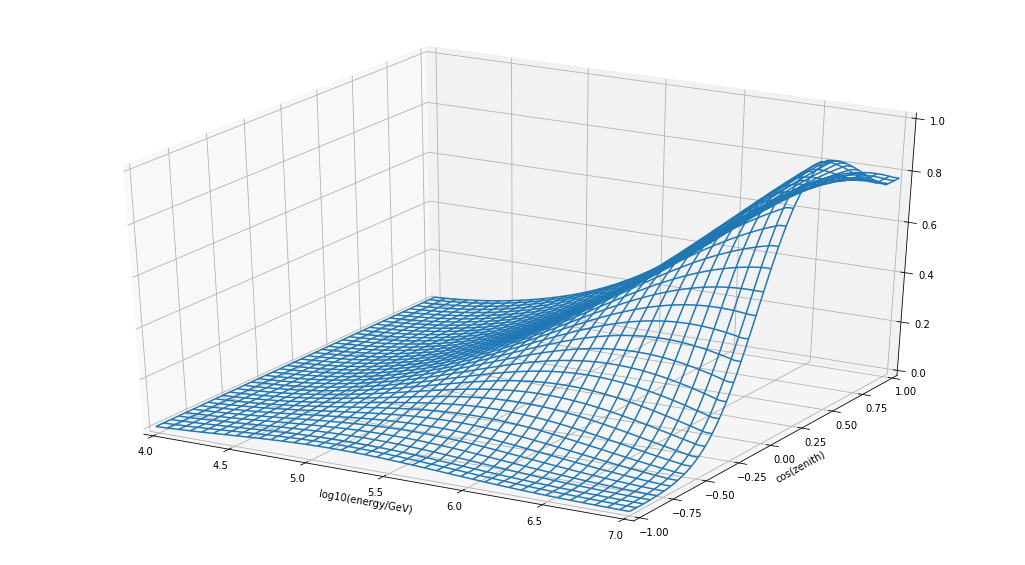

In [20]:
# Plot un-logged version scaled by max value
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
aeff_max = max(10**aeff.aeff_vals)
surf = ax.plot_wireframe(xx, yy, 10**z/aeff_max, rstride=5, cstride=5)

ax.set_xlabel('log10(energy/GeV)')
ax.set_ylabel('cos(zenith)')
ax.set_xlim([4.0, 7.0])
ax.set_ylim([-1.0, 1.0])
ax.set_zlim([0, 1.0]);

## Dealing with bounds

Noticed that because of how knots were defined in `aeff.spline`, there were strange effects going on in the simulation. To fix this can handle bounds properly in the Stan code. 

In [56]:
# Decide which spline to use

# aeff.spline
xknots, yknots = aeff.spline.get_knots()
c = aeff.spline.get_coeffs()

p = 3  
xknots = np.unique(xknots)
yknots = np.unique(yknots)
Nx = len(xknots)+p-1 
Ny = len(yknots)+p-1 
c = c.reshape(Nx, Ny)

print ('Bounds to watch out for:')
print('cosz:', min(yknots), max(yknots))
print('log10E:', min(xknots), max(xknots))

Bounds to watch out for:
cosz: -0.9 0.9
log10E: 2.909987829785444 6.969959412088619


## Simulation to check Aeff effects in cosz

Simulate particles injected with a single $E$ to verify Aeff is working correctly for cosz. Noticed problems with `aeff.spline` for cosz <= -0.9, and cosz >= 0.9.

In [57]:
# Compile Stan model
sim = stan_utility.compile_model(filename = 'stan/aeff_test_cosz.stan', 
                                 model_name = 'aeff_test_cosz', 
                                 include_paths = 'stan/')

Using cached StanModel


In [58]:
sim_input = {}
sim_input['N'] = 2000
sim_input['log10E'] = 6.0
sim_input['aeff_max'] = aeff_max

# Spline
sim_input['p'] = p
sim_input['Lknots_x'] = len(xknots)
sim_input['Lknots_y'] = len(yknots)
sim_input['xknots'] = xknots
sim_input['yknots'] = yknots
sim_input['c'] = c

In [59]:
# Simulate
simulation = sim.sampling(data=sim_input, iter=1, chains=1, 
                          algorithm="Fixed_param", seed=random_seed)

In [60]:
from fancy.interfaces.stan import Direction
from fancy.plotting import AllSkyMap

# Extract output
event = simulation.extract(['direction'])['direction'][0]
pdet = simulation.extract(['pdet'])['pdet'][0]
zenith = simulation.extract(['zenith'])['zenith'][0]
event = Direction(event)
ra = event.d.icrs.ra.rad
dec = event.d.icrs.dec.rad

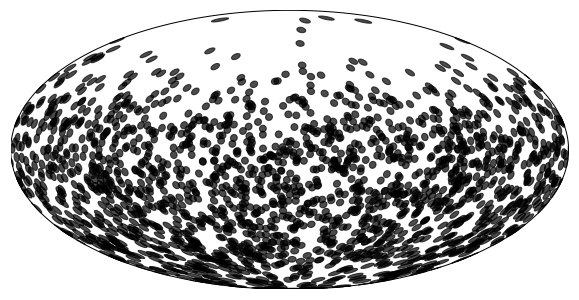

In [61]:
from matplotlib.colors import LinearSegmentedColormap

# Skymap
fig, ax = plt.subplots()
fig.set_size_inches((10, 8))
skymap = AllSkyMap(projection = 'hammer', lon_0=0, lat_0=0);
for r, d in zip(ra, dec):
    skymap.tissot(np.rad2deg(r), np.rad2deg(d), 2, 30, color='k', alpha=0.7)

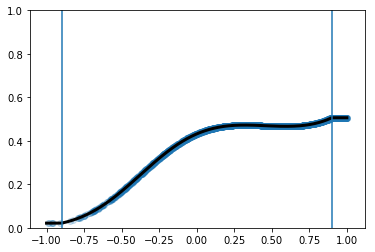

In [62]:
# Compare with original aeff.spline
log10E = sim_input['log10E']
cosz = np.linspace(-1, 1, 1000)
pdet_true = [10**aeff.eval(log10E, _)[0][0] / aeff_max for _ in cosz]

fig, ax = plt.subplots()
ax.plot(cosz, pdet_true, color='k', lw=3)
ax.scatter(np.cos(zenith), pdet, alpha=0.2)
ax.set_ylim(0, 1)
ax.axvline(-0.9)
ax.axvline(0.9)

## Simulation to check Aeff in E
At a single zenith angle, send particles uniformly in energy. Again, notice problems for extreme values of cosz and E>6.95.

In [63]:
# Compile Stan model
sim = stan_utility.compile_model(filename = 'stan/aeff_test_E.stan', 
                                 model_name = 'aeff_test_E', include_paths = 'stan/')

Using cached StanModel


In [64]:
sim_input = {}
sim_input['N'] = 2000
sim_input['cosz'] = 0.95 # choose problem value!
sim_input['aeff_max'] = aeff_max

# Spline
sim_input['p'] = p
sim_input['Lknots_x'] = len(xknots)
sim_input['Lknots_y'] = len(yknots)
sim_input['xknots'] = xknots
sim_input['yknots'] = yknots
sim_input['c'] = c

In [65]:
# Simulate
simulation = sim.sampling(data=sim_input, iter=1, chains=1, 
                          algorithm="Fixed_param", seed=random_seed)

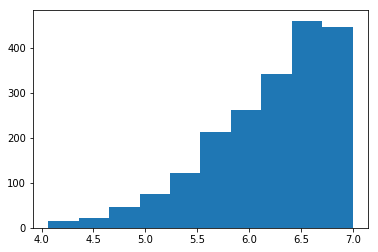

In [66]:
log10E = simulation.extract(['log10E'])['log10E'][0]
pdet = simulation.extract(['pdet'])['pdet'][0]

fig, ax = plt.subplots()
ax.hist(log10E);

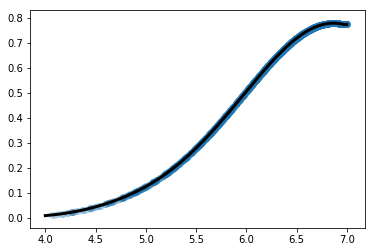

In [67]:
# compare
log10E_true = np.linspace(4.0, 7.0, 1000)
cosz = sim_input['cosz']
pdet_true = [10**aeff.eval(_, cosz)[0][0] / aeff_max for _ in log10E_true]

fig, ax = plt.subplots()
ax.plot(log10E_true, pdet_true, color='k', lw=3)
ax.scatter(log10E, pdet, alpha=0.2)

These problems can be fixed by setting the bounds properly in the Stan code.